In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import warnings
from sklearn.cluster import KMeans
from kneed import KneeLocator
import collections
import auxiliary_functions
import pprint
import json

In [7]:
import inspect
inspect.getargspec(auxiliary_functions.ranking_calculation)

C:\Users\elsal\AppData\Local\Temp\ipykernel_18812\3484617465.py:2: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  inspect.getargspec(auxiliary_functions.ranking_calculation)


ArgSpec(args=['i', 'index_top_3', 'value_top_3', 'user_queries', 'average_cluster', 'key', 'count'], varargs=None, keywords=None, defaults=None)

In [8]:
###################################################################
## Read data
###################################################################

data = pd.read_csv("./data_house/database.csv", sep = ',') 
column_names = data.columns
n = len(data.columns)
print("Dataset shape:", data.shape)

# Normalize data
data_normal = pd.DataFrame(StandardScaler().fit_transform(data), columns = column_names)

Dataset shape: (10000, 13)


In [9]:
###################################################################
## Dimensionality reduction
###################################################################

pca = PCA(n_components = 0.70)
data = pca.fit_transform(data_normal)
data = pd.DataFrame(data)
print(data.shape)

(10000, 9)


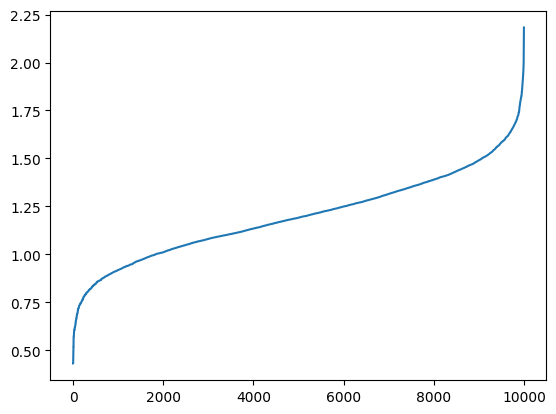

In [10]:

###################################################################
## Find parameters of DBSCAN
###################################################################

neighb = NearestNeighbors(n_neighbors=n) 
nbrs=neighb.fit(data) # fitting the data to the object
distances,indices=nbrs.kneighbors(data) # finding the nearest neighbours

# Sort and plot the distances results
plt.figure()
distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.plot(distances) # plotting the distances
plt.savefig('./data_house/figure_pre_dbsacn') # showing the plot

In [11]:
###################################################################
## DBSCAN
###################################################################
# clusters
print('\n-----------------DBSCAN--------------\n')
dbscan = DBSCAN(eps = 1.5, min_samples = 8).fit(data) 
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_ # getting the labels

print("Labels for DBSCAN: ",np.unique(labels))
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('n_clusters for DBSCAN: ', n_clusters_)


-----------------DBSCAN--------------

Labels for DBSCAN:  [-1  0  1  2  3  4]
n_clusters for DBSCAN:  5



-----------------k-means--------------

knee elbow:  10


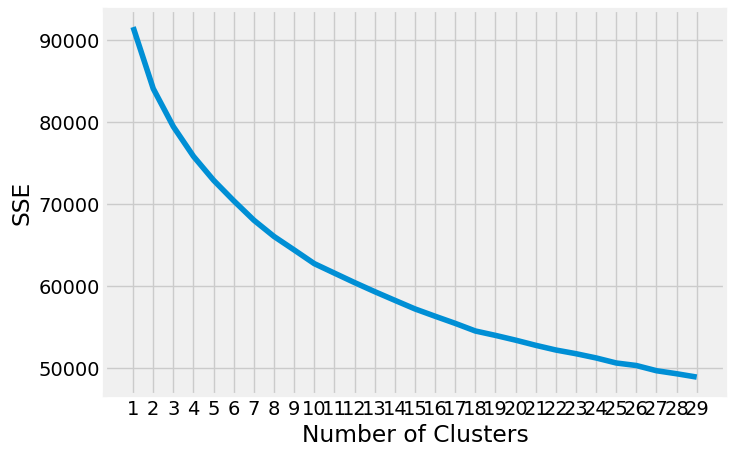

In [6]:

###################################################################
## K-MEANS
###################################################################
print('\n-----------------k-means--------------\n')
kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 300,"random_state": 42}
# A list holds the SSE values for each k
sse = []
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.style.use("fivethirtyeight")
plt.plot(range(1, 30), sse)
plt.xticks(range(1, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.savefig('./data_house/kmeans.png')

kl = KneeLocator(range(1, 30), sse, curve="convex", direction="decreasing")
print('knee elbow: ',kl.elbow)

In [12]:
#kmeans = KMeans(init="random", n_clusters=kl.elbow, n_init=10, max_iter=300,random_state=42)
kmeans = KMeans(init="random", n_clusters=10, n_init=10, max_iter=300,random_state=42)
kmeans.fit(data)
print('labels k-means: ', np.unique(kmeans.labels_))
n_clusters_kmeans = len(set(kmeans.labels_)) - (1 if -1 in kmeans.labels_ else 0)
print('n_clusters for kmeans: ', n_clusters_kmeans)

labels k-means:  [0 1 2 3 4 5 6 7 8 9]
n_clusters for kmeans:  10



----------------Plot-----------------



C:\Users\elsal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\elsal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


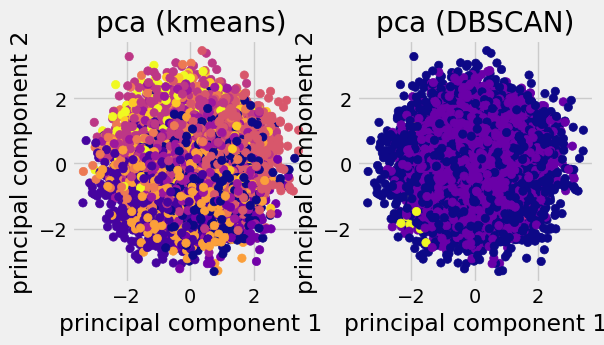

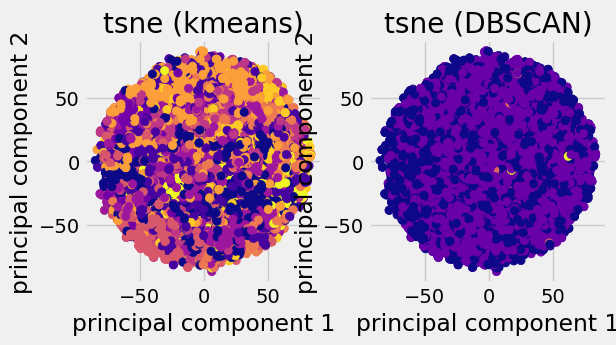

In [8]:

###################################################################
## Plot
###################################################################
print('\n----------------Plot-----------------\n')
auxiliary_functions.plot_data(data, data_normal, kmeans.labels_, labels)

In [13]:

###################################################################
## Assign queries to clusters
###################################################################
print('-------------------query assignement-------------\n')

queries =  pd.read_csv("./data_house/queries_to_use.csv", sep = ',', index_col = 0)
data = pd.read_csv("./data_house/database.csv", sep = ',') 
data['cluster_id_kmeans'] = kmeans.labels_
data['cluster_id_dbscan'] = labels
column_names_queries = queries.columns

matching_outputs = auxiliary_functions.queries_to_tuples(queries,data, kmeans.labels_, n)
matching_outputs.to_csv('data_house/matching_outputs.csv', header = False, sep = ',', index=False)
maxValueIndex = matching_outputs.idxmax(axis = 1)
queries['kmeans_label_id'] = maxValueIndex


print('-------------queries-----------\n')
print("Used clusters: ", np.unique(queries['kmeans_label_id']))
event_counts = collections.Counter(queries['kmeans_label_id'])
pprint.pprint(event_counts)

print('-------------database-----------\n')
print("Database: ", np.unique(data['cluster_id_kmeans']))
event_counts = collections.Counter(data['cluster_id_kmeans'])
pprint.pprint(event_counts)


-------------------query assignement-------------

-------------queries-----------

Used clusters:  ['4' '8' '9']
Counter({'9': 821, '4': 593, '8': 586})
-------------database-----------

Database:  [0 1 2 3 4 5 6 7 8 9]
Counter({5: 1035,
         0: 1026,
         8: 1024,
         4: 1006,
         3: 995,
         7: 991,
         1: 990,
         9: 983,
         6: 979,
         2: 971})


In [19]:
###################################################################
## Jaccard similarity between queries
###################################################################
print('--------------jaccard similarity-----------\n')

dict_queries = auxiliary_functions.queries_as_sets(queries)
    
user_queries =  pd.read_csv("./data_house/user_queries.csv", sep = ',')
recomendations_index = pd.DataFrame(0, index = range(len(user_queries)), columns =['user_id','top1', 'top2', 'top3', 'top4', 'top5'])
recomendations_value = pd.DataFrame(0, index = range(len(user_queries)), columns =['user_id','top1', 'top2', 'top3', 'top4', 'top5'])
count_value = pd.DataFrame(0, index = range(len(user_queries)), columns =['user_id','case1', 'case2', 'case3', 'prop1', 'prop2', 'prop3'])

for i in range(len(user_queries)):
    gvn_jsonfile = open("./data_house/query_set.json")
    json_data = json.load(gvn_jsonfile)
    
    print("---------------user {}------------\n ".format(i+1))
    dict_cluster = {}
    average_cluster = {}
    user_queries_non_nan = []
    user_queries_nan = []
    
    # We create lists containing the indexes of no ranked queries and ranked queries
    for t,j in user_queries.iloc[i][1:].items():           
      if (np.isnan(j)):
          user_queries_nan.append(t)
      else:
          user_queries_non_nan.append(t)
    n_nan_queries = len(user_queries_nan)
    count = [0,0,0]

    # Create a dictionary
    for j in range(len(np.unique(queries['kmeans_label_id']))):
        dict_cluster.update({str(np.unique(queries['kmeans_label_id'])[j]) : []})
        average_cluster.update({str(np.unique(queries['kmeans_label_id'])[j]) : []})
    
    for k in range(len(user_queries_non_nan)):
        dict_cluster[str(queries['kmeans_label_id'].iloc[k])].append(user_queries_non_nan[k])
            
    # We calculate the average ranking of ranked queries in each cluster
    for j in range(len(np.unique(queries['kmeans_label_id']))):
        key = str(np.unique(queries['kmeans_label_id'])[j])
        ranking_temp = []
        for query_id in dict_cluster[key]:
            ranking_temp.append(user_queries[str(query_id)].iloc[i])
        average_cluster[key].append(sum(ranking_temp)/len(ranking_temp))

    index_top_ranking = [0,0,0,0,0]
    value_top_ranking = [0,0,0,0,0]

    for item in user_queries_nan:
        set_query_nan = json_data[str(item)]
        
        key = str(queries['kmeans_label_id'].iloc[int(item)])
        similarity = []
        index_top_3 = [0,0,0]
        value_top_3 =[0,0,0]
                
        for query_id in dict_cluster[key]:
            set_query_non_nan = json_data[str(query_id)]
            similarity_value = auxiliary_functions.jaccard_similarity(set_query_non_nan, set_query_nan)
            # similarity.append(similarity_value)
            
            if similarity_value > min(value_top_3):
                min_index = value_top_3.index(min(value_top_3))
                index_top_3[min_index] = int(query_id)
                value_top_3[min_index] = similarity_value 
        
        # Fill the ranking of the current nan query for the current user by averaging the top 3 values
        ranking, count = auxiliary_functions.ranking_calculation(i,index_top_3, value_top_3, user_queries, average_cluster, key, count)
        user_queries.at[i, str(item)] = ranking
        
        
        min_value = min(value_top_ranking) 
        if ranking > min_value:
            min_index_ranking = value_top_ranking.index(min(value_top_ranking))
            index_top_ranking[min_index_ranking] = int(item)
            value_top_ranking[min_index_ranking] =  float(ranking) 
        
        
    # Return top k queries which were previously nan and now have a high rating
    #print('Any left nan values: ', user_queries.iloc[i].hasnans)
    #print("Reccommended queries for user {}: {} .".format(user_queries['user_id'].iloc[i], sort_by_indexes(index_top_ranking, value_top_ranking, True)))
    
    # Write in the dataframe 
    recomendations_index.iloc[i] = [user_queries['user_id'].iloc[i]] + auxiliary_functions.sort_by_indexes(index_top_ranking, value_top_ranking, True)
    value_top_ranking.sort(reverse = True)
    recomendations_value.iloc[i] = [user_queries['user_id'].iloc[i]] + value_top_ranking
    prop_count = [round(i/n_nan_queries, 2) for i in count]
    print(count, prop_count)
    count_value.iloc[i] = [user_queries['user_id'].iloc[i]] + count + prop_count
    
    # We write a data frame with the counts and the proportions
    

# We save the dataframe   
recomendations_index.to_csv("./data_house/recomendations_index.csv", sep = ',', header = True, index = False)
recomendations_value.to_csv("./data_house/recomendations_value.csv", sep = ',', header = True, index = False)

--------------jaccard similarity-----------

---------------user 1------------
 
[0, 809, 420] [0.0, 0.66, 0.34]
---------------user 2------------
 
[0, 743, 474] [0.0, 0.61, 0.39]
---------------user 3------------
 
[0, 778, 448] [0.0, 0.63, 0.37]
---------------user 4------------
 
[8, 701, 507] [0.01, 0.58, 0.42]
---------------user 5------------
 
[9, 725, 593] [0.01, 0.55, 0.45]
---------------user 6------------
 
[0, 1023, 522] [0.0, 0.66, 0.34]
---------------user 7------------
 
[11, 764, 637] [0.01, 0.54, 0.45]
---------------user 8------------
 
[0, 910, 434] [0.0, 0.68, 0.32]
---------------user 9------------
 
[0, 988, 550] [0.0, 0.64, 0.36]
---------------user 10------------
 
[0, 860, 451] [0.0, 0.66, 0.34]
---------------user 11------------
 
[0, 897, 476] [0.0, 0.65, 0.35]
---------------user 12------------
 
[8, 709, 540] [0.01, 0.56, 0.43]
---------------user 13------------
 
[0, 935, 500] [0.0, 0.65, 0.35]
---------------user 14------------
 
[0, 1062, 489] [0.0, 0.6

In [20]:
###################################################################
## Fill out utility matrix
###################################################################
user_queries.to_csv('./data_house/user_queries_fill.csv', header = True, sep = ',')
user_queries =  pd.read_csv("./data_house/user_queries_fill.csv", sep = ',')


In [21]:
print(user_queries.iloc[:5, 1:11])

       user_id      0      1      2      3      4      5     6      7      8
0  158-86-3113  56.82  76.00  35.08  69.19  67.24  50.68  40.0  71.67  71.56
1  241-10-5564  38.95  44.00  26.00  56.00  38.15  45.23  31.0  44.00  56.00
2  338-27-8772  41.66  35.04  53.00  36.91  32.29  48.69  49.0  24.91  34.00
3  495-50-0640  78.00  72.00  75.37  98.00  96.00  66.13  66.0  84.27  73.32
4  710-35-1509  65.00  74.00  46.00  49.91  65.49  57.00  57.0  74.00  59.10


In [22]:
print(recomendations_index[:5])

       user_id  top1  top2  top3  top4  top5
0  158-86-3113   776    40   979  1069   448
1  241-10-5564   157   293   729   563   649
2  338-27-8772   420   485   665   694   971
3  495-50-0640   356   400   403   130   418
4  710-35-1509   356    94   403   406   130


In [23]:
print(recomendations_value[:5])

       user_id  top1  top2  top3  top4  top5
0  158-86-3113  89.0  89.0  89.0  89.0  89.0
1  241-10-5564  59.0  59.0  59.0  59.0  59.0
2  338-27-8772  55.0  55.0  55.0  55.0  55.0
3  495-50-0640  99.0  99.0  99.0  99.0  99.0
4  710-35-1509  77.0  77.0  77.0  77.0  77.0


In [24]:
print(count_value[:10])

       user_id  case1  case2  case3  prop1  prop2  prop3
0  158-86-3113      0    809    420   0.00   0.66   0.34
1  241-10-5564      0    743    474   0.00   0.61   0.39
2  338-27-8772      0    778    448   0.00   0.63   0.37
3  495-50-0640      8    701    507   0.01   0.58   0.42
4  710-35-1509      9    725    593   0.01   0.55   0.45
5  491-06-8879      0   1023    522   0.00   0.66   0.34
6  309-45-7913     11    764    637   0.01   0.54   0.45
7  429-46-1809      0    910    434   0.00   0.68   0.32
8  076-95-1602      0    988    550   0.00   0.64   0.36
9  731-61-3487      0    860    451   0.00   0.66   0.34


In [25]:
count_value.mean(axis = 0)

C:\Users\elsal\AppData\Local\Temp\ipykernel_18812\2205735361.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  count_value.mean(axis = 0)


case1      3.0200
case2    878.1400
case3    500.0800
prop1      0.0027
prop2      0.6351
prop3      0.3625
dtype: float64